In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [3]:
# q_in, q_switch, q_out1, q_out2
EJs = [22, 21, 24, 23]
ECs = [0.25, 0.4, 0.4, 0.28]
gs = [0.15, 0.15, 0.15] # g12, g23, g24
cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print(qubit_freqs[0], qubit_freqs[1], qubit_freqs[2], qubit_freqs[3])
print(alphas[0], alphas[1], alphas[2], alphas[3])

6.372742057696335 7.77498011533865 8.342661717476677 6.885510681734878
-0.27581343076221465 -0.4576807972507133 -0.45269668911903693 -0.31017075005341965


In [5]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS

qram.check_state_mapping(n=3)

100%|██████████| 320/320 [00:43<00:00,  7.30it/s]

Good enough for dressed states mappings.


True

In [4]:
times = np.linspace(0, 700, 200)
# times = np.linspace(0, 300, 200)

seq = PulseSequence(start_time=0)
qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12)
qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.04)
qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.07)
qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12) # repeat of pulse 0
qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.18)

# qram.add_const_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07, t_pulse_factor=1)
# qram.add_const_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.03, t_offset=-seq.prev_pulse_length(), t_pulse_factor=1)
# qram.add_const_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07, t_offset=-seq.prev_pulse_length()) # repeat of pulse 0
# qram.add_const_pi_pulse(seq, 'gfgg', 'ggge', amp=0.06, t_offset=-seq.prev_pulse_length())
# qram.add_const_pi_pulse(seq, 'eegg', 'eggg', amp=0.04, t_offset=0, t_pulse_factor=1)

# seq.wait(seq.const_pulse(wd=get_wd('eggg', 'gfgg'), amp=0.02, t_pulse=57.0470))
# seq.wait(seq.const_pulse(wd=get_wd('gfgg', 'ggeg'), amp=0.15, t_pulse=105.7047))
# seq.wait(seq.const_pulse(wd=get_wd('eegg', 'eggg'), amp=0.05, t_pulse=110.7383))
# seq.wait(seq.const_pulse(wd=get_wd('eggg', 'gfgg'), amp=0.02, t_pulse=1000))
# seq.wait(seq.const_pulse(wd=get_wd('gfgg', 'ggge'), amp=0.1, t_pulse=87.2483))

[-8.815341288805616, 6.790158176784272, 7.757209636271664, -8.815341288805616, 8.309919289407338]


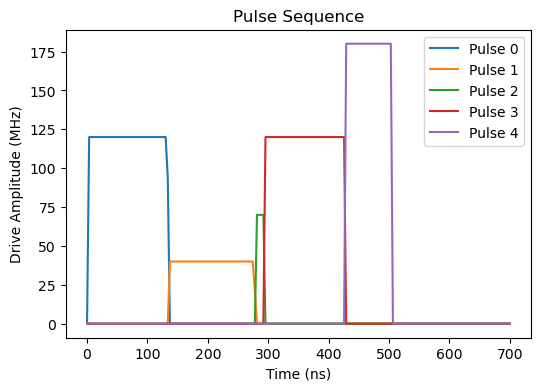

In [5]:
envelope_seq = seq.get_envelope_seq()
print(seq.pulse_freqs)
for i in range(len(envelope_seq)):
    plt.plot(times, [envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [6]:
incl_dissipation = True
# incl_dissipation = False

T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

c_ops = [
    np.sqrt(1/T1)*qram.a1,
    np.sqrt(1/T1)*qram.a2,
    np.sqrt(1/T1)*qram.a3,
    np.sqrt(1/T1)*qram.a4,
]

In [7]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(1/2) * qram.state('eggg') + np.sqrt(1/2) * qram.state('eegg') # QRAM start

if incl_dissipation:
    result = qt.mcsolve(qram.H_solver_array(seq, times), psi0, times, c_ops, progress_bar=True, options=qt.Options(nsteps=1000)).states
else: result = qt.mesolve(qram.H_solver(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=10000)).states

10.0%. Run time: 1118.45s. Est. time left: 00:02:47:46
20.0%. Run time: 2097.97s. Est. time left: 00:02:19:51
30.0%. Run time: 3070.53s. Est. time left: 00:01:59:24
40.0%. Run time: 4043.28s. Est. time left: 00:01:41:04
50.0%. Run time: 5115.21s. Est. time left: 00:01:25:15
60.0%. Run time: 6113.78s. Est. time left: 00:01:07:55
70.0%. Run time: 7091.35s. Est. time left: 00:00:50:39
80.0%. Run time: 8057.88s. Est. time left: 00:00:33:34
90.0%. Run time: 9116.42s. Est. time left: 00:00:16:52
100.0%. Run time: 10062.19s. Est. time left: 00:00:00:00
Total run time: 10062.32s


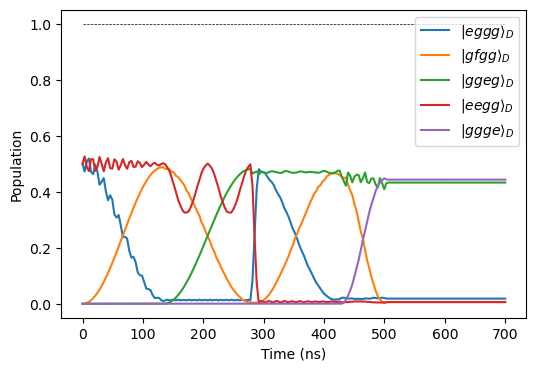

In [10]:
plt.plot(times, [np.abs(qram.state('eggg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|eggg\rangle_D$')
plt.plot(times, [np.abs(qram.state('gfgg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|gfgg\rangle_D$')
plt.plot(times, [np.abs(qram.state('ggeg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|ggeg\rangle_D$')
plt.plot(times, [np.abs(qram.state('eegg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|eegg\rangle_D$')
plt.plot(times, [np.abs(qram.state('ggge').overlap(result[t]))**2 for t in range(len(times))], label=r'$|ggge\rangle_D$')
# plt.plot(times, [np.abs(state('gggg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|gggg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

plt.plot(times, [1]*len(times), 'k--', linewidth=0.5)
plt.legend()
# plt.xlim(750, 1000)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
plt.show()

In [11]:
T = 700 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                sum_psi += np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
print('Sum probabilities:', sum_psi)
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                if prob > 0.01: print(qram.level_nums_to_name([i1, i2, i3, i4]), prob)

Sum probabilities: 0.9771885765508918
Non-zero levels:
gggg 0.014645932998287283
ggge 0.4431540227351518
ggeg 0.4326812134117221
ggee 0.010241892056026195
ggfg 0.019284555751564302
geeg 0.014621948462246405
eggg 0.01830259462741004


In [ ]:
print('want', qram.get_wd('eggg', 'eegg')/2/np.pi)
print('resonant to', qram.get_wd('ggeg', 'geeg')/2/np.pi)
print('2 photon transition to', qram.get_wd('eggg', 'efgg')/2/np.pi)

want -7.117683920077098
resonant to -7.4204071348408345
2 photon transition to -13.026971604059492


In [196]:
print('want', qram.get_wd('gfgg', 'ggeg')/2/np.pi)
print(qram.get_wd('eegg', 'eege')/2/np.pi)

want 6.805256249350793
-6.86587733158145
